# Kaggle competition - predicting house prices

Working notebook for Kaggle competition.


In [346]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split

from sklearn.decomposition import PCA

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_regression

from sklearn.model_selection import cross_val_score, KFold

from sklearn.metrics import mean_squared_error

from sklearn import linear_model

from sklearn.linear_model import Lasso
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge

import matplotlib.pyplot as plt

%matplotlib inline

## Check source data

Read in source data set

In [347]:
train_data = pd.read_csv('kaggle_train.csv')
test_data = pd.read_csv('kaggle_test.csv') 

In [348]:
train_data.head()

df_train = train_data.reset_index(drop=True)
df_test = test_data

In [349]:
df_train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


Let's check which columns contain values stored as text and how heterogenous values in them are, also to spot potential categories.

In [350]:
check_df = df_train.select_dtypes(include=['object'])

for c in check_df:
    print(check_df[c].value_counts())

RL         1151
RM          218
FV           65
RH           16
C (all)      10
Name: MSZoning, dtype: int64
Pave    1454
Grvl       6
Name: Street, dtype: int64
Grvl    50
Pave    41
Name: Alley, dtype: int64
Reg    925
IR1    484
IR2     41
IR3     10
Name: LotShape, dtype: int64
Lvl    1311
Bnk      63
HLS      50
Low      36
Name: LandContour, dtype: int64
AllPub    1459
NoSeWa       1
Name: Utilities, dtype: int64
Inside     1052
Corner      263
CulDSac      94
FR2          47
FR3           4
Name: LotConfig, dtype: int64
Gtl    1382
Mod      65
Sev      13
Name: LandSlope, dtype: int64
NAmes      225
CollgCr    150
OldTown    113
Edwards    100
Somerst     86
Gilbert     79
NridgHt     77
Sawyer      74
NWAmes      73
SawyerW     59
BrkSide     58
Crawfor     51
Mitchel     49
NoRidge     41
Timber      38
IDOTRR      37
ClearCr     28
StoneBr     25
SWISU       25
MeadowV     17
Blmngtn     17
BrDale      16
Veenker     11
NPkVill      9
Blueste      2
Name: Neighborhood, dtype:

Target column is price.

In [351]:
target_col = 'SalePrice'

In [352]:
df_train[target_col].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

Check on data distribution

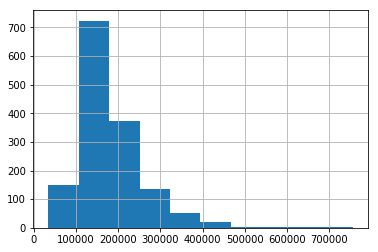

In [353]:
df_train[target_col].hist()

Skew is: 1.8828757597682129


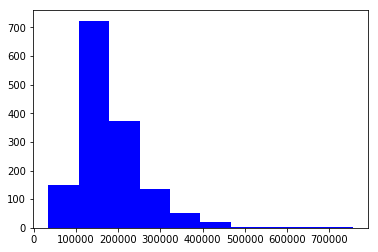

In [354]:
print ("Skew is:", df_train[target_col].skew())
plt.hist(df_train[target_col], color='blue')
plt.show()

Data is left-skewed a lot and so for fitting the model it would help to use log transformation.

Skew is: 0.12133506220520406


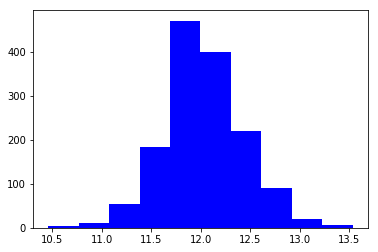

In [355]:
target = np.log(df_train[target_col])
print ("Skew is:", target.skew())
plt.hist(target, color='blue')
plt.show()

## Feature engineering

Exlude not useful columns, such as ID, month of last sale, order etc.

In [356]:
columns_to_drop = ['MSSubClass', 'YrSold', 'MiscVal', 'MoSold', 'Id']

Keep only columns that add value e.g. columns with value that is same for 95 percent of records, or if variability of categorical value is too big would not help.

In [357]:
VARIABILITY_TRESHOLD = 0.95

#check nominal columns and select those that could be dropped
object_df = df_train.select_dtypes( include=["object"] )    

for c in object_df:
    spread = object_df[c].value_counts()
    spread_pct = spread / len(object_df)
        
    for i in spread_pct:
        # not useful if big percent of values explain by one 
        if i > VARIABILITY_TRESHOLD:
            columns_to_drop.append(c)

        # if there are too many values, it is not useful either
        if ( len(spread_pct) / df_train.shape[0] ) > (1-VARIABILITY_TRESHOLD):
            if c not in to_drop:
                columns_to_drop.append(c)
                

Check on missing values, if there are too many missing, it does not make sense to keep it.

In [358]:
ALLOWED_NA_PERCENTAGE = 0.05
   
# check missing value in column
check_null = df_train.isnull().sum() / len(df_train)
check_cols = check_null.index    

# if columns has less than small percent it is not flagged for dropping
def should_be_dropped(x):
    if x<ALLOWED_NA_PERCENTAGE:
        return False
    return True

not_acceptable_missing_mask = check_null.apply(lambda x: should_be_dropped(x))
columns_to_drop.extend( check_cols[ not_acceptable_missing_mask ] )

Check on correlation with target value.

In [359]:
CORR_TRESHOLD = 0.8

num_df = df_train.select_dtypes( include=['int16', 'int32', 'int64', 'float16', 'float32', 'float64'] )
    
corr_data = num_df.astype('float64')
corr_data.drop(target_col, axis =1,inplace=True)
corr = corr_data.corrwith( df_train[target_col] )
corr_high = corr[ abs(corr) > CORR_TRESHOLD ]

columns_to_drop.extend( corr_high.index.tolist() )

In [360]:
df_train = df_train.drop( columns_to_drop, axis=1 )
df_test = df_test.drop( columns_to_drop, axis=1 )

Check if there is an opportunity to create new feature based on categorical values

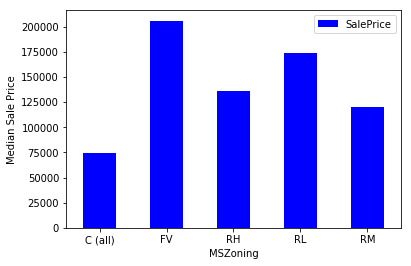

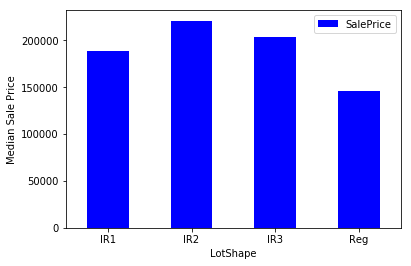

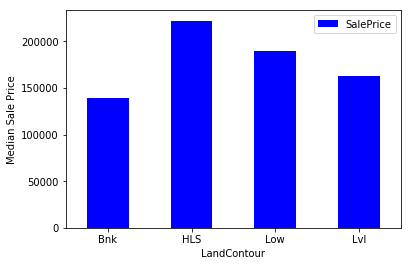

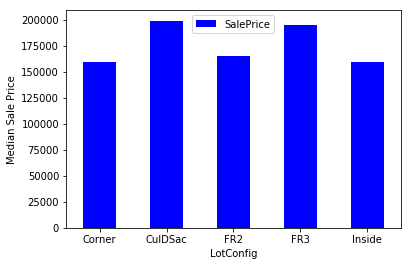

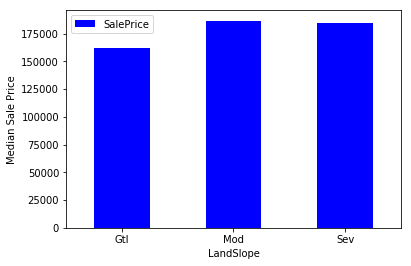

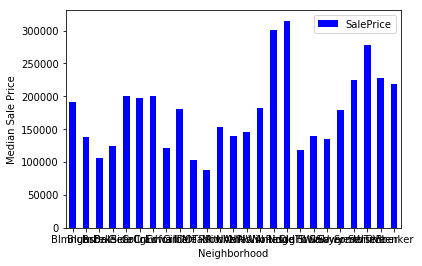

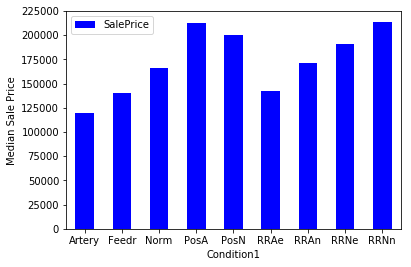

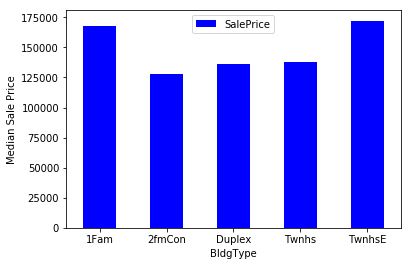

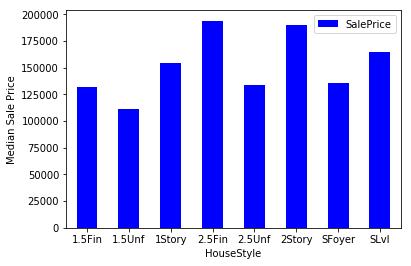

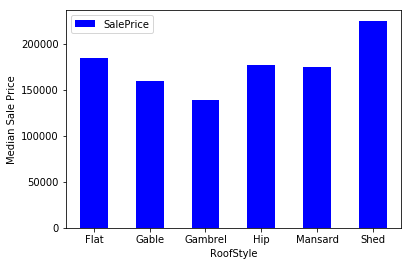

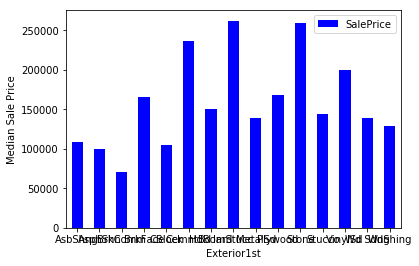

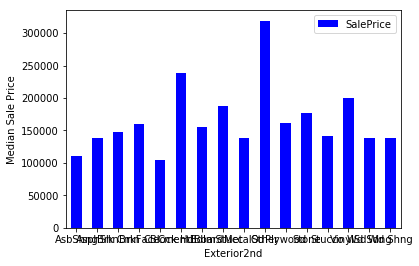

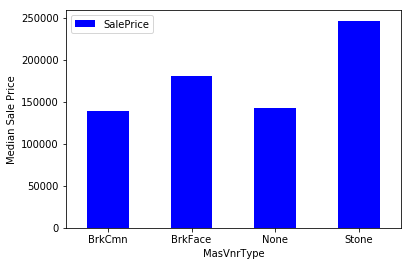

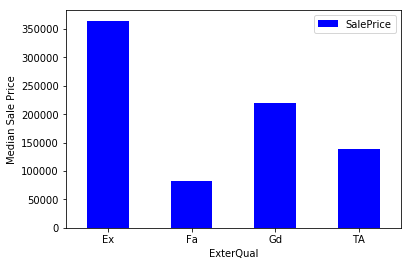

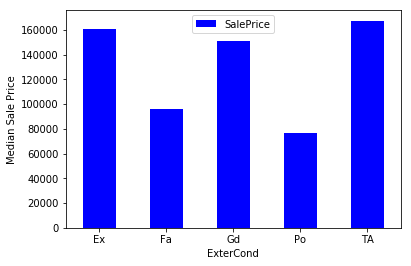

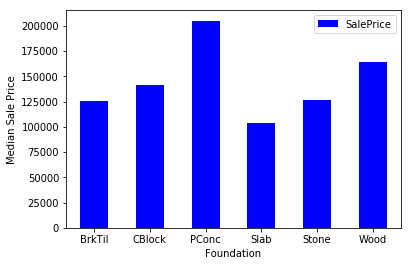

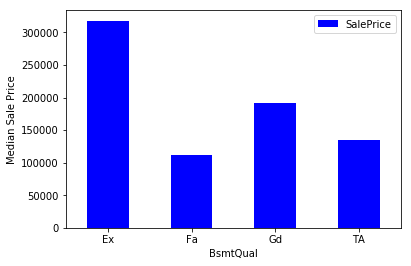

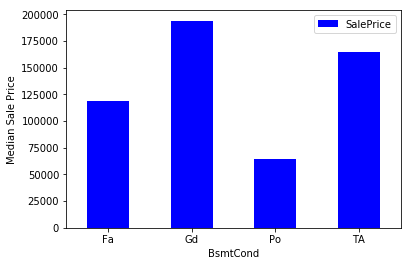

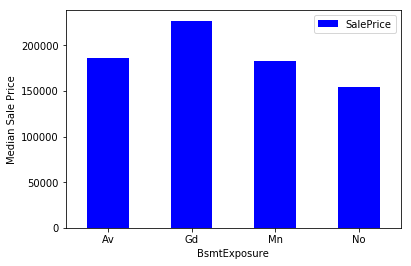

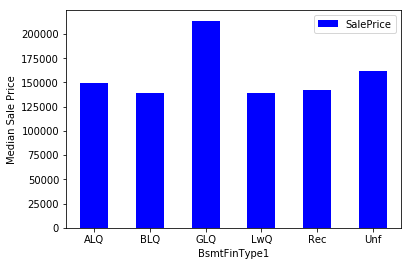

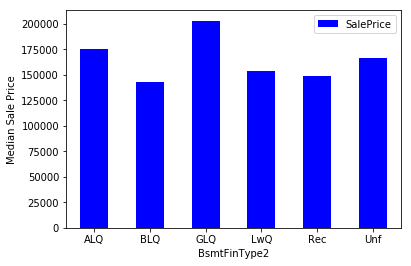

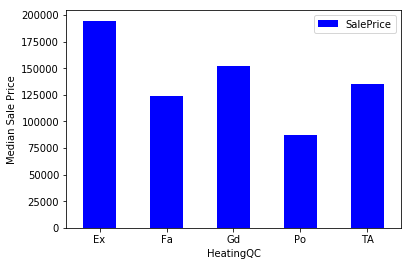

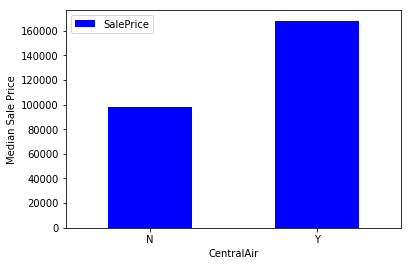

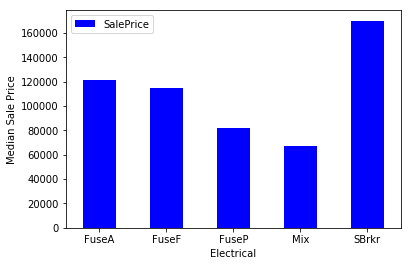

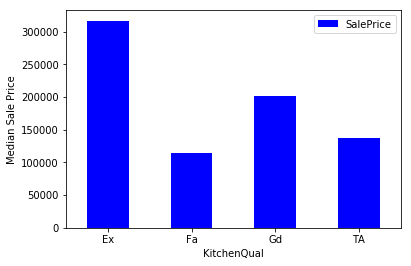

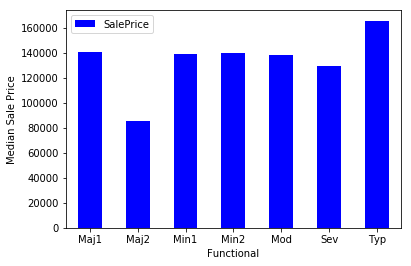

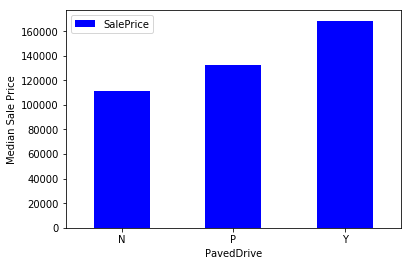

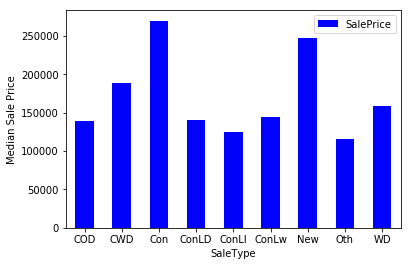

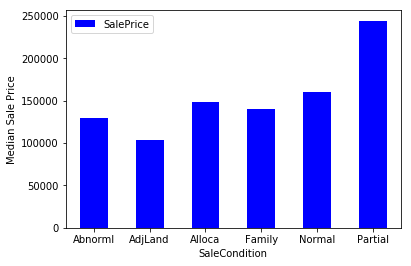

In [361]:
object_df_columns = df_train.select_dtypes( include=["object"] ).columns.tolist()

for c in object_df_columns:

    condition_pivot = df_train.pivot_table(index=c, values = target_col, aggfunc=np.median)
    condition_pivot.plot(kind='bar', color='blue')

    plt.xlabel(c)
    plt.ylabel('Median Sale Price')
    plt.xticks(rotation=0)
    plt.show()

From all categorical values, following stand out:

SaleCondition: Partial

SaleType: Con and New

... so it is worth to transform those columns.

In [362]:
def encode(x): return 1 if x == 'Partial' else 0

df_train['SaleCondition'] = df_train['SaleCondition'].apply(encode).astype('float64')
df_test['SaleCondition'] = df_test['SaleCondition'].apply(encode).astype('float64')

In [363]:
def encode(x): return 1 if x in ['Con','New'] else 0

df_train['SaleType'] = df_train['SaleType'].apply(encode).astype('float64')
df_test['SaleType'] = df_test['SaleType'].apply(encode).astype('float64')

Documentation about data explains more about quality values that can be mapped onto scale. <br>

Encoding can be done in a way that sets higher numerical value for exceptional / excellent quality and lower for fair / poor quality, however, it needs to be set in conjunction with understanding of relationship of each value to target variable (SalePrice), so proper review of charts above is critical. <br> <br>


Paved Drive <br>

3  Y	Paved <br>
1  P	Partial Pavement <br>
0  N	Dirt/Gravel <br>


KitchenQual <br>

6  Ex	Excellent <br>
3  Gd	Good <br>
2  TA	Typical/Average <br>
1  Fa	Fair <br>
0  Po	Poor <br>


HeatingQC <br>

6  Ex	Excellent <br>
3  Gd	Good <br>
2  TA	Average/Typical <br>
1  Fa	Fair <br>
0  Po	Poor <br>


BsmtCond <br>

6  Ex	Excellent <br>
3  Gd	Good <br>
2  TA	Typical - slight dampness allowed <br>
1  Fa	Fair - dampness or some cracking or settling <br>
0  Po	Poor - Severe cracking, settling, or wetness <br>
0  NA	No Basement <br>


BsmtQual <br>

6  Ex	Excellent (100+ inches)	 <br>
3  Gd	Good (90-99 inches) <br>
2  TA	Typical (80-89 inches) <br>
1  Fa	Fair (70-79 inches) <br>
0  Po	Poor (<70 inches <br>
0  NA	No Basement <br>


ExterCond <br>

5  Ex	Excellent <br>
5  Gd	Good <br>
5  TA	Average/Typical <br>
1  Fa	Fair <br>
0  Po	Poor <br>


ExterQual <br>

5  Ex	Excellent <br>
3  Gd	Good <br>
2  TA	Average/Typical <br>
1  Fa	Fair <br>
0  Po	Poor <br>

In [364]:
df_train.columns

Index(['MSZoning', 'LotArea', 'LotShape', 'LandContour', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'ExterQual',
       'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure',
       'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF',
       'TotalBsmtSF', 'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF',
       '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath',
       'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'GarageCars', 'GarageArea',
       'PavedDrive', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch',
       'ScreenPorch', 'PoolArea', 'SaleType', 'SaleCondition', 'SalePrice'],
      dtype='object')

In [365]:
def encode(x):
    map_dict = {
        "Ex": 6,
        "Gd": 3,
        "TA": 2,
        "Fa": 1,
        "Po": 0
    }
    return map_dict[x] if x in map_dict else x

df_train['KitchenQual'] = df_train['KitchenQual'].apply(lambda x: encode(x)).astype('float64')
df_test['KitchenQual'] = df_test['KitchenQual'].apply(lambda x: encode(x)).astype('float64')

In [366]:
def encode(x):
    map_dict = {
        "Ex": 6,
        "Gd": 3,
        "TA": 2,
        "Fa": 1,
        "Po": 0
    }
    return map_dict[x] if x in map_dict else x

df_train['HeatingQC'] = df_train['HeatingQC'].apply(lambda x: encode(x)).astype('float64')
df_test['HeatingQC'] = df_test['HeatingQC'].apply(lambda x: encode(x)).astype('float64')

In [367]:
def encode(x):
    map_dict = {
        "Ex": 6,
        "Gd": 3,
        "TA": 2,
        "Fa": 1,
        "Po": 0,
        "NA": 0
    }
    return map_dict[x] if x in map_dict else x

df_train['BsmtCond'] = df_train['BsmtCond'].apply(lambda x: encode(x)).astype('float64')
df_test['BsmtCond'] = df_test['BsmtCond'].apply(lambda x: encode(x)).astype('float64')

In [368]:
def encode(x):
    map_dict = {
        "Ex": 6,
        "Gd": 3,
        "TA": 2,
        "Fa": 1,
        "Po": 0,
        "NA": 0
    }
    return map_dict[x] if x in map_dict else x

df_train['BsmtQual'] = df_train['BsmtQual'].apply(lambda x: encode(x)).astype('float64')
df_test['BsmtQual'] = df_test['BsmtQual'].apply(lambda x: encode(x)).astype('float64')

In [369]:
def encode(x):
    map_dict = {
        "Ex": 5,
        "Gd": 5,
        "TA": 5,
        "Fa": 1,
        "Po": 0
    }
    return map_dict[x] if x in map_dict else x

df_train['ExterCond'] = df_train['ExterCond'].apply(lambda x: encode(x)).astype('float64')
df_test['ExterCond'] = df_test['ExterCond'].apply(lambda x: encode(x)).astype('float64')

In [370]:
def encode(x):
    map_dict = {
        "Ex": 5,
        "Gd": 3,
        "TA": 2,
        "Fa": 1,
        "Po": 0
    }
    return map_dict[x] if x in map_dict else x

df_train['ExterQual'] = df_train['ExterQual'].apply(lambda x: encode(x)).astype('float64')
df_test['ExterQual'] = df_test['ExterQual'].apply(lambda x: encode(x)).astype('float64')

Convert numerical all to float type

In [371]:
num_df_train = df_train.select_dtypes( include=['int16', 'int32', 'int64', 'float16', 'float32', 'float64'] ).astype('float64')

num_df_test = df_test.select_dtypes( include=['int16', 'int32', 'int64', 'float16', 'float32', 'float64'] ).astype('float64')

Transform data about YearBuilt and YearRemodAdd to show diff to current year.

In [372]:
if 'YearBuilt' in num_df_train.columns.tolist():
    num_df_train['Age'] = num_df_train['YearBuilt'].apply(lambda x: 2018-x)    
    num_df_train = num_df_train.drop( ['YearBuilt'], axis=1 )

if 'YearBuilt' in num_df_test.columns.tolist():
    num_df_test['Age'] = num_df_test['YearBuilt'].apply(lambda x: 2018-x)    
    num_df_test = num_df_test.drop( ['YearBuilt'], axis=1 )
    
    
if 'YearRemodAdd' in num_df_train.columns.tolist():
    num_df_train['AgeRemodAdd'] = num_df_train['YearRemodAdd'].apply(lambda x: 2018-x)    
    num_df_train = num_df_train.drop( ['YearRemodAdd'], axis=1 )

if 'YearRemodAdd' in num_df_test.columns.tolist():
    num_df_test['AgeRemodAdd'] = num_df_test['YearRemodAdd'].apply(lambda x: 2018-x)    
    num_df_test = num_df_test.drop( ['YearRemodAdd'], axis=1 )


Normalize numerical with min-max scaling (exept target column).

In [373]:
num_df_train_norm = (num_df_train - num_df_train.min()) / (num_df_train.max() - num_df_train.min()) 
# will not normalize target column, will use original one
num_df_train_norm = num_df_train_norm.drop(target_col, axis=1)

num_df_test_norm = (num_df_test - num_df_test.min()) / (num_df_test.max() - num_df_test.min()) 
# test does not have test col

For other text-based columns, create dummy columns, and use only those.

In [374]:
new_object_df_train = pd.DataFrame()

object_df_train = df_train.select_dtypes(include=['object'])
if object_df_train.shape[1]>0:
    new_object_df_train = pd.get_dummies(object_df_train)    
    

new_object_df_test = pd.DataFrame()

object_df_test = df_test.select_dtypes(include=['object'])
if object_df_test.shape[1]>0:
    new_object_df_test = pd.get_dummies(object_df_test)

Log transform target column.

In [375]:
target_df = np.log(df_train[target_col])

Bring that all together.

In [376]:
final_df_train = pd.concat([ num_df_train_norm, target_df, new_object_df_train ], axis=1)

final_df_test = pd.concat([ num_df_test_norm, new_object_df_test ], axis=1)

Fill the missing values with an average value.

In [377]:
data_train = final_df_train.select_dtypes(include=[np.number]).interpolate().dropna()

data_test = final_df_test.select_dtypes(include=[np.number]).interpolate().dropna()

Check if there are any NAs left.

In [378]:
sum(data_train.isnull().sum() != 0)

0

Records left for training:

In [379]:
data_train.shape[0]

1460

Split data set to feature set and target

In [380]:
X_train_all = data_train[ [col for col in data_train.columns if col not in [target_col]] ]
y_train_all = data_train[target_col]

Feature columns for further analysis:

In [381]:
data_train.shape[1]-1

186

Let's try to select best possible features by examination of correlation against target value.

In [400]:
# feature extraction
Kval = 17
select_k_best_classifier = SelectKBest(score_func=f_regression, k=Kval)
fit = select_k_best_classifier.fit(X_train_all, y_train_all)

# summarize scores
#np.set_printoptions(precision=3)

results = pd.DataFrame( 
    list(zip(X_train_all.columns.tolist(), fit.scores_, fit.pvalues_)), 
    columns=["Feature","Score","Pvalue"] )

print(results.sort_values('Pvalue', ascending = True)[:Kval])

all_feature_names = X_train_all.columns.tolist()
mask = select_k_best_classifier.get_support()

best_features_list = []
for bool, feature in zip(mask, all_feature_names):
    if bool:
        best_features_list.append(feature)

print(best_features_list)

              Feature        Score         Pvalue
1         OverallQual  2930.795149   0.000000e+00
16          GrLivArea  1408.119051  3.060209e-216
26         GarageCars  1258.349043  3.093756e-199
4           ExterQual  1119.329389  1.371088e-182
27         GarageArea  1071.733084  1.106255e-176
23        KitchenQual   915.246514  1.908591e-156
11        TotalBsmtSF   873.710639  7.534551e-151
6            BsmtQual   840.087425  3.027024e-146
13           1stFlrSF   807.334244  1.074698e-141
19           FullBath   798.099817  2.118958e-140
36                Age   764.780024  1.103567e-135
37        AgeRemodAdd   685.840903  3.211481e-124
24       TotRmsAbvGrd   582.893720  1.292804e-108
149  Foundation_PConc   572.050043  6.325386e-107
25         Fireplaces   459.312902   8.421350e-89
12          HeatingQC   440.696024   1.050473e-85
159  BsmtFinType1_GLQ   351.544301   1.931212e-70
['OverallQual', 'ExterQual', 'BsmtQual', 'TotalBsmtSF', 'HeatingQC', '1stFlrSF', 'GrLivArea', 'FullB

Check on outliers

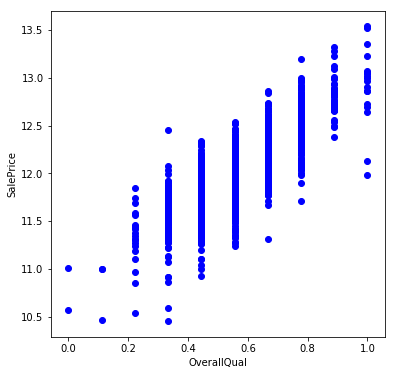

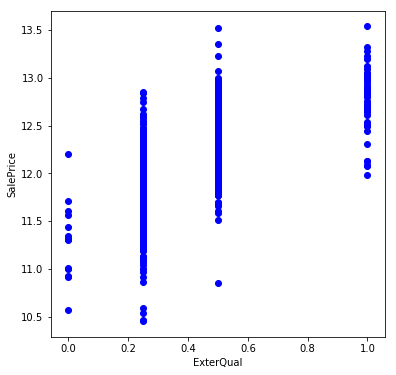

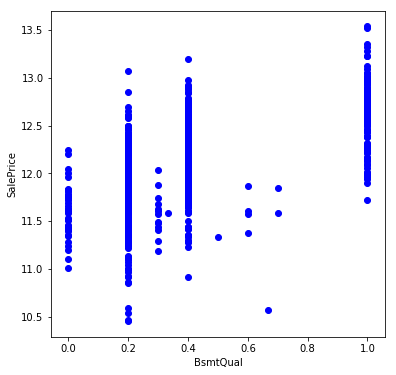

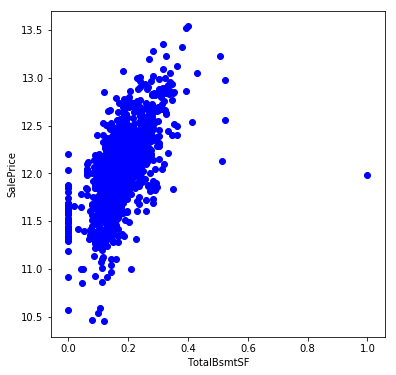

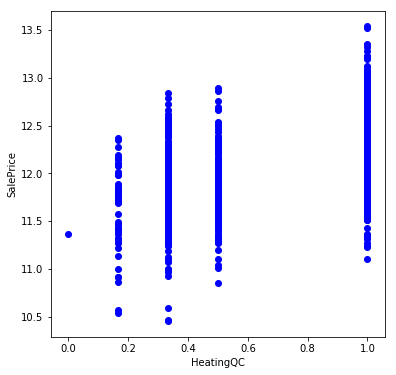

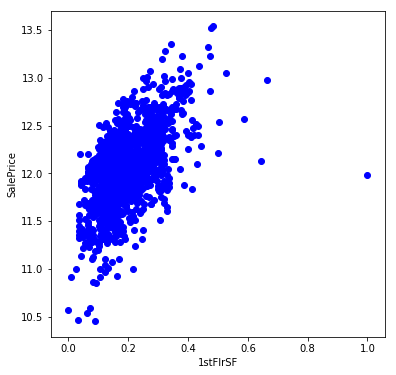

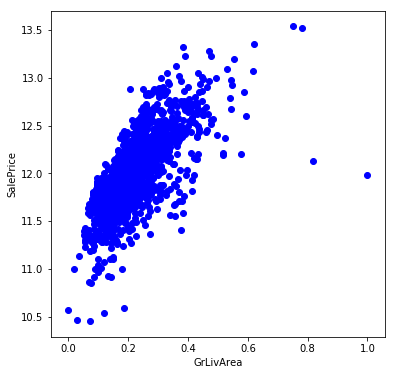

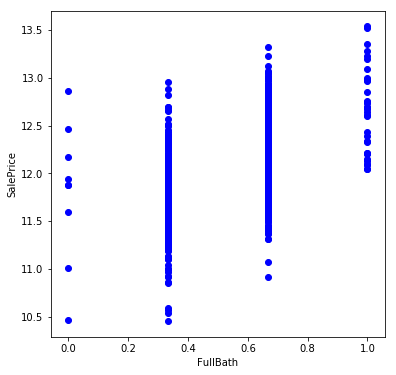

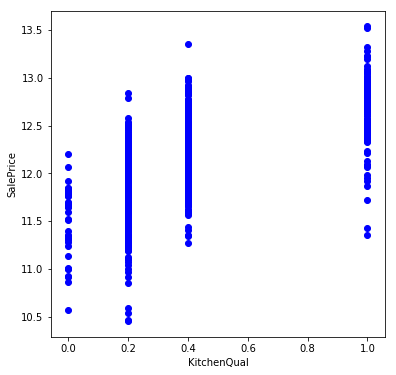

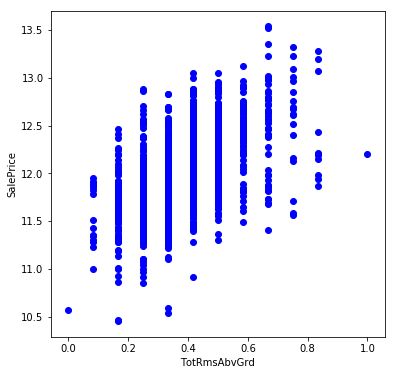

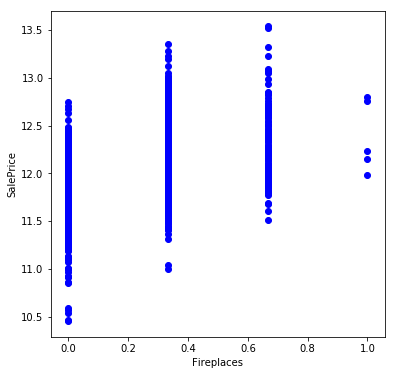

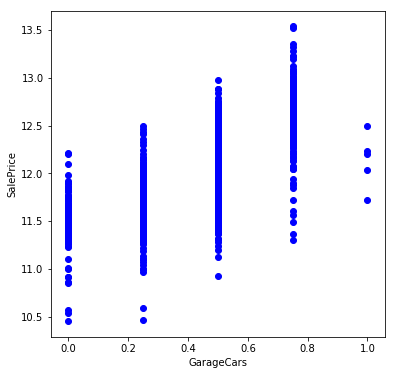

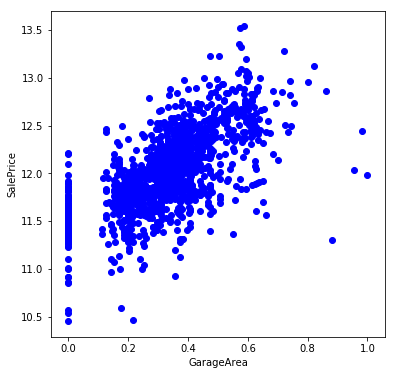

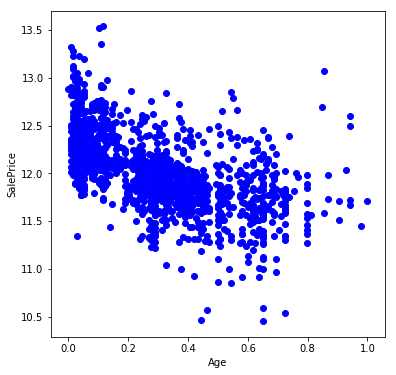

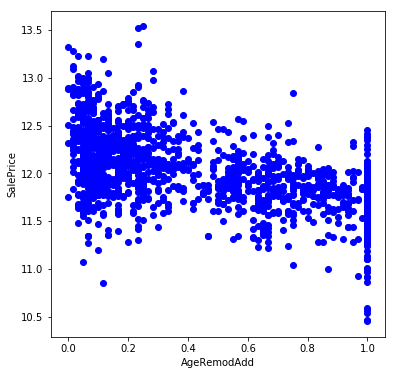

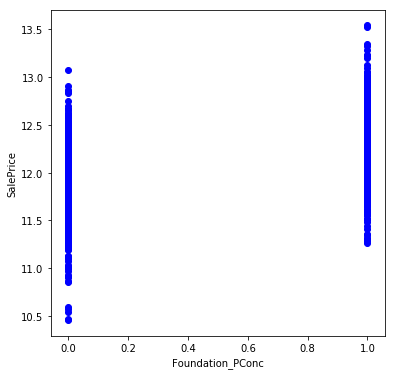

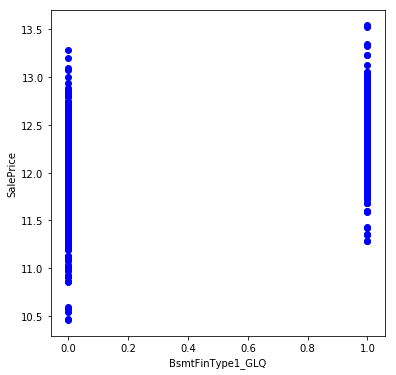

In [401]:
for f in best_features_list:
    plt.figure(figsize=(6,6))
    
    plt.scatter(X_train_all[f],y_train_all, color='b')
    
    plt.xlabel(f)
    plt.ylabel(target_col)
    
    plt.show()

Outliers identified in: TotalBsmtSF, GrLivArea, 1stFlrSF, GarageArea. These needs to be eliminated.

In [402]:
data_train = data_train[ 
    ( data_train['1stFlrSF'] <0.6 ) & 
    ( data_train['GrLivArea']<0.7 ) & 
    ( data_train['TotalBsmtSF']<0.6 ) & 
    ( data_train['GarageArea']<0.8 ) ]  

Final X and y set

In [403]:
X_train = data_train[best_features_list]
y_train = data_train[target_col]

X_test = data_test[best_features_list]

Principal Component Analysis (PCA)

PCA, when applied to normalized data, can help to effectively reduce dimensionality of data. New components are main dimensions of variation in data.
<br>

Way less components were chosen to identify biggest drivers influencing target values. They explain >90 percent of variation in dataset.

In [404]:
def do_pca(df, n_level):
    
    pca = PCA(n_components=n_level)
    principalComponents = pca.fit_transform(df)
    df_principal = pd.DataFrame(data = principalComponents, columns = [ 'pc_'+str(i) for i in range(1,n_level+1) ])
    
    return pca, df_principal

Text(0,0.5,'cumulative variance explained')

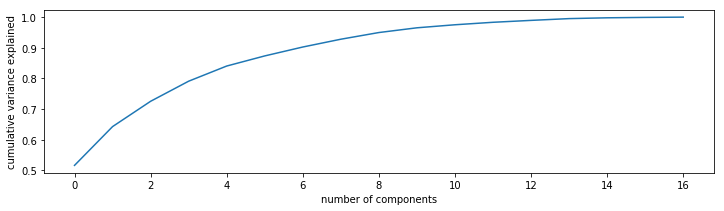

In [405]:
plt.figure(figsize=(12,3))

pca, X_principal = do_pca(X_train, len(X_train.columns.tolist()))    

plt.plot( np.cumsum( pca.explained_variance_ratio_ ) )
plt.xlabel('number of components')
plt.ylabel('cumulative variance explained')

In [406]:
np.cumsum( pca.explained_variance_ratio_ )

array([0.51585778, 0.64248829, 0.72517271, 0.79079659, 0.84029502,
       0.87334149, 0.90240485, 0.92786907, 0.94968998, 0.96514877,
       0.9750712 , 0.98317528, 0.98938621, 0.99517934, 0.99781161,
       0.99912035, 1.        ])

2 components explain more than 80 percent of variability in data, 4 components more than 90 percent, 10 components almost 100 percent.

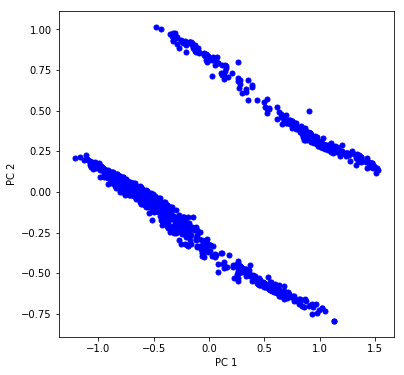

In [407]:
pca, X_principal = do_pca(X_train, 2)

plt.figure(figsize=(6,6))
plt.scatter(X_principal['pc_1'],X_principal['pc_2'], color='b', s=25, marker="o")
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.show()

Let's investigate which columns influence those components mainly.

In [408]:
df_explain_pca = pd.DataFrame( pca.components_, columns=X_train.columns, index = ['PC1','PC2'] )

df_explain_pca

,OverallQual,ExterQual,BsmtQual,TotalBsmtSF,HeatingQC,1stFlrSF,GrLivArea,FullBath,KitchenQual,TotRmsAbvGrd,Fireplaces,GarageCars,GarageArea,Age,AgeRemodAdd,Foundation_PConc,BsmtFinType1_GLQ
PC1,0.151867,0.163434,0.202931,0.041559,0.296674,0.040257,0.051975,0.138525,0.175360,0.04811,0.061653,0.153054,0.109794,-0.231006,-0.356142,0.598426,0.430266
PC2,-0.040114,-0.049575,-0.036255,0.003016,-0.187236,0.001371,-0.040461,-0.101299,-0.039797,-0.07199,-0.024603,-0.056439,-0.027903,0.032461,0.155243,-0.341056,0.891540


TOP 5 columns influencing components:

In [409]:
np.abs(df_explain_pca.loc['PC1']).sort_values(ascending=False)[:5]

Foundation_PConc    0.598426
BsmtFinType1_GLQ    0.430266
AgeRemodAdd         0.356142
HeatingQC           0.296674
Age                 0.231006
Name: PC1, dtype: float64

In [410]:
np.abs(df_explain_pca.loc['PC2']).sort_values(ascending=False)[:5]

BsmtFinType1_GLQ    0.891540
Foundation_PConc    0.341056
HeatingQC           0.187236
AgeRemodAdd         0.155243
FullBath            0.101299
Name: PC2, dtype: float64

Is it possible to train model with reduced dimensionality data set, using 10 features?

Refit train data with PCA components

In [411]:
pca, X_principal = do_pca(X_train, 8)
X_train_pca_reduced = pca.fit_transform(X_train)

X_train_pca_reduced = pd.DataFrame(X_train_pca_reduced)

After several tests, it look like that using KBest helps to choose feature set which are better for fitting the model.

There is not a big difference in amount of columns (hence time for training), and score is also better, hence usage of PCA is not the way to move forward.

## Select the best model

Try out various models and parameters for those models (~ hyperparameter optimization), evaluate scores and pick the best one.

Validation function will ensure score by cross validation on 4-folds.

In [413]:
n_folds = 4

def get_rmse_for_model(model):    
    
    X_ = X_train
    #X_ = X_train_pca_reduced    
    
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(X_.values)
    rmse= np.sqrt(-cross_val_score(model, X_.values, y_train, scoring="neg_mean_squared_error", cv = kf))
    return(rmse.mean())

In [414]:
def print_results(model):
    score = get_rmse_for_model(model)
    print("Score:", score)

Linear regression

In [415]:
LR = linear_model.LinearRegression()

print_results(LR)

Score: 0.14459452317528215


Lasso

In [416]:
Lasso =  make_pipeline( RobustScaler(), Lasso(alpha =0.005, random_state=1))

print_results(Lasso)

TypeError: 'Pipeline' object is not callable

Kernel Ridge

In [317]:
param_alpha = [ 0.1*i for i in range(1,10) ]
param_degree = [ i for i in range(1,10) ]
param_coef0 = [ 0.5*i for i in range(1,10) ]

results = []
results_params = []

for p1 in param_alpha:
    for p2 in param_degree:
        for p3 in param_coef0:

            KRR = KernelRidge(alpha=p1, kernel='polynomial', degree=p2, coef0=p3) 
            
            results.append(get_rmse_for_model(KRR))
            results_params.append( (p1,p2,p3) )

print('Best score:', min(results))
print('Achieved with parameters (alpha, degree, coef0):', results_params [ results.index(min(results)) ]   )

Best score: 0.1457955613863538
Achieved with parameters (alpha, degree, coef0): (0.1, 4, 2.5)


Gradient Boosting

In [420]:
param_estimators = [ 100*i for i in range(1,20) ]
param_max_depth = [ i for i in range(1,12) ]

results = []
results_params = []

for p1 in param_max_depth:
    for p2 in param_estimators:
        GBR = GradientBoostingRegressor(
            n_estimators=p2, 
            learning_rate=0.01, 
            max_depth=p1, 
            max_features='sqrt', 
            random_state =5)  
        
        results.append(get_rmse_for_model(GBR))
        results_params.append( (p1,p2) )
        
        
print('Best score:', min(results))
print('Achieved with parameters (max_depth, estimators):', results_params [ results.index(min(results)) ]   )

Best score: 0.13912665023406512
Achieved with parameters (max_depth, estimators): (2, 1900)


Random Forest

In [ ]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X_train, y_train, test_size=(1/n_folds), random_state=42)

param_estimators = [ 100*i for i in range(1,40) ]

results = []
results_params = []

for p in param_estimators:
    RF = RandomForestRegressor(n_estimators = p, random_state = 42)
    RF.fit(X_train2.values, y_train2)

    predictions = RF.predict(X_test2)

    RF_rmse = mean_squared_error(y_test2, predictions)**(1/2)
    
    results.append(RF_rmse)
    results_params.append( p )

print('Best score:', min(results))
print('Achieved with parameters (estimators):', results_params [ results.index(min(results)) ]  )

Both Gradient Boosting and Random Forest are ensembles, one based on boosting (guess which), another on bagging.

Train best model.

In [53]:
#final_model = RandomForestRegressor(n_estimators = 3200, random_state = 42)

In [421]:
final_model = GBR = GradientBoostingRegressor(
            n_estimators= 1900, 
            learning_rate=0.01, 
            max_depth= 2, 
            max_features='sqrt', 
            random_state =5) 

In [55]:
#final_model = KernelRidge(alpha=0.3, kernel='polynomial', degree=8, coef0=1.0) 

In [422]:
final_model.fit(X_train.values, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.01, loss='ls', max_depth=2,
             max_features='sqrt', max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=1900,
             presort='auto', random_state=5, subsample=1.0, verbose=0,
             warm_start=False)

## Predicting values for submission

Predict values based on test set and generate CSV file for submission to Kaggle.

In [423]:
predictions = pd.Series( final_model.predict(X_test) )
final_predictions = np.exp(predictions)

In [424]:
submission_df = pd.concat( [ test_data['Id'], pd.Series(final_predictions) ] , axis=1)

In [425]:
submission_df.rename(index=str, columns={ 0: "SalePrice"}, inplace=True)

In [426]:
submission_df.dropna(inplace=True)

In [427]:
submission_df['Id'] = submission_df['Id'].astype('int32')

In [428]:
submission_df.set_index('Id', inplace=True)

In [429]:
submission_df.to_csv('kaggle_submission_52.csv')